In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.models import Model

np.random.seed(123)
tf.random.set_seed(123)

In [2]:
from sklearn.metrics import mean_absolute_percentage_error

In [3]:
df = pd.read_csv('airline_passengers.csv', index_col='Month', parse_dates=True)

In [5]:
df['LogPassengers'] = np.log(df['Passengers'])
Ntest = 12
train = df.iloc[:-Ntest]
test = df.iloc[-Ntest:]
# boolean series to index df rows
train_idx = df.index <= train.index[-1]
test_idx = df.index > train.index[-1]
df['DiffLogPassengers'] = df['LogPassengers'].diff()
# Make supervised dataset
series = df['DiffLogPassengers'].dropna().to_numpy()

T = 10
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T, 1)
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)
Xtrain, Ytrain = X[:-Ntest], Y[:-Ntest]
Xtest, Ytest = X[-Ntest:], Y[-Ntest:]

X.shape (133, 10, 1) Y.shape (133,)


In [6]:
# CNN
i = Input(shape=(T, 1))
x = Conv1D(16, 3, activation='relu')(i)
x = MaxPooling1D(2)(x)
x = Conv1D(32, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(1)(x)
model = Model(i, x)

In [7]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 1)]           0         
                                                                 
 conv1d (Conv1D)             (None, 8, 16)             64        
                                                                 
 max_pooling1d (MaxPooling1  (None, 4, 16)             0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 2, 32)             1568      
                                                                 
 global_max_pooling1d (Glob  (None, 32)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 1)                 33    

In [8]:
model.compile(
  loss='mse',
  optimizer='adam',
)

In [9]:
r = model.fit(
  Xtrain,
  Ytrain,
  epochs=100,
  validation_data=(Xtest, Ytest)
)

Epoch 1/100
4/4 [==============================] - 0s 17ms/step - loss: 0.0130 - val_loss: 0.0121
Epoch 2/100
4/4 [==============================] - 0s 3ms/step - loss: 0.0114 - val_loss: 0.0117
Epoch 3/100
4/4 [==============================] - 0s 3ms/step - loss: 0.0108 - val_loss: 0.0113
Epoch 4/100
4/4 [==============================] - 0s 3ms/step - loss: 0.0102 - val_loss: 0.0108
Epoch 5/100
4/4 [==============================] - 0s 3ms/step - loss: 0.0097 - val_loss: 0.0102
Epoch 6/100
4/4 [==============================] - 0s 3ms/step - loss: 0.0094 - val_loss: 0.0098
Epoch 7/100
4/4 [==============================] - 0s 3ms/step - loss: 0.0090 - val_loss: 0.0095
Epoch 8/100
4/4 [==============================] - 0s 3ms/step - loss: 0.0086 - val_loss: 0.0092
Epoch 9/100
4/4 [==============================] - 0s 3ms/step - loss: 0.0083 - val_loss: 0.0090
Epoch 10/100
4/4 [==============================] - 0s 3ms/step - loss: 0.0080 - val_loss: 0.0088
Epoch 11/100
4/4 [==========

4/4 [==============================] - 0s 3ms/step - loss: 8.9428e-04 - val_loss: 0.0043
Epoch 85/100
4/4 [==============================] - 0s 3ms/step - loss: 8.6835e-04 - val_loss: 0.0043
Epoch 86/100
4/4 [==============================] - 0s 3ms/step - loss: 8.5269e-04 - val_loss: 0.0042
Epoch 87/100
4/4 [==============================] - 0s 3ms/step - loss: 8.4184e-04 - val_loss: 0.0043
Epoch 88/100
4/4 [==============================] - 0s 3ms/step - loss: 8.4264e-04 - val_loss: 0.0043
Epoch 89/100
4/4 [==============================] - 0s 3ms/step - loss: 8.5112e-04 - val_loss: 0.0043
Epoch 90/100
4/4 [==============================] - 0s 3ms/step - loss: 8.3866e-04 - val_loss: 0.0045
Epoch 91/100
4/4 [==============================] - 0s 3ms/step - loss: 8.4102e-04 - val_loss: 0.0042
Epoch 92/100
4/4 [==============================] - 0s 3ms/step - loss: 8.2642e-04 - val_loss: 0.0044
Epoch 93/100
4/4 [==============================] - 0s 3ms/step - loss: 8.2081e-04 - val_loss: 

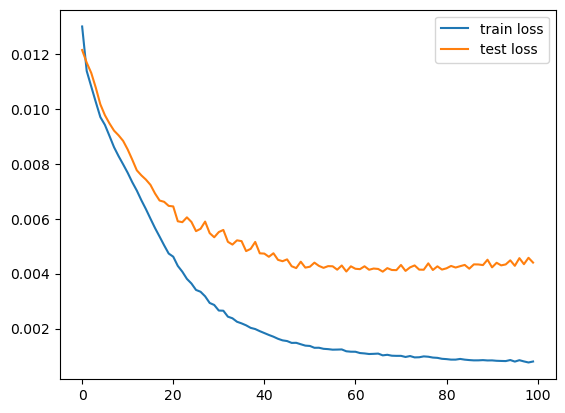

In [10]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

In [11]:
train_idx[:T+1] = False # first T

In [12]:
Ptrain = model.predict(Xtrain).flatten()
Ptest = model.predict(Xtest).flatten()

1/1 [==============================] - 0s 6ms/step


In [13]:
# Store diff predictions
df.loc[train_idx, 'Diff Train Prediction'] = Ptrain
df.loc[test_idx, 'Diff Test Prediction'] = Ptest

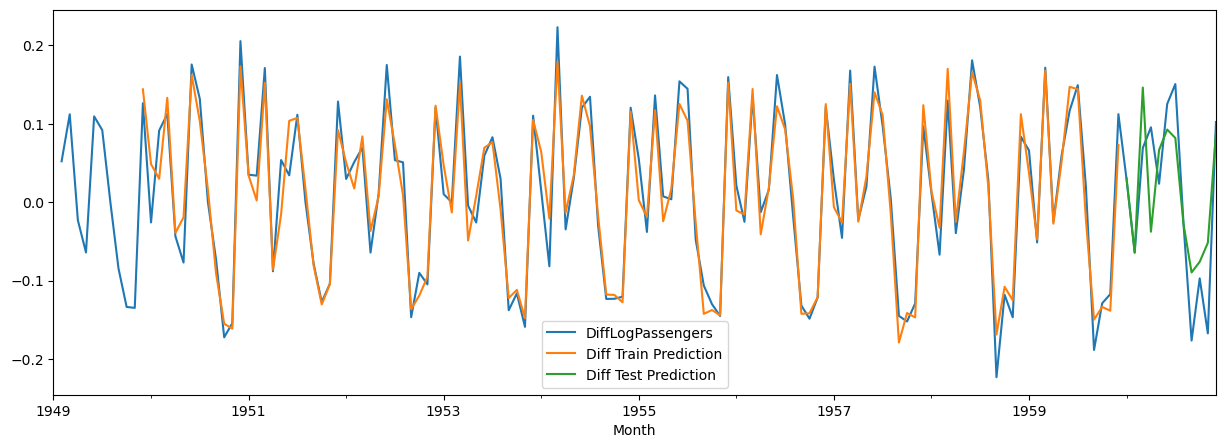

In [14]:
cols = ['DiffLogPassengers',
        'Diff Train Prediction',
        'Diff Test Prediction']
df[cols].plot(figsize=(15, 5));

In [15]:
# Needed to compute un-differenced predictions
df['ShiftLogPassengers'] = df['LogPassengers'].shift(1)
prev = df['ShiftLogPassengers']

In [16]:
# Last-known train value
last_train = train.iloc[-1]['LogPassengers']

In [17]:
# 1-step forecast
df.loc[train_idx, '1step_train'] = prev[train_idx] + Ptrain
df.loc[test_idx, '1step_test'] = prev[test_idx] + Ptest

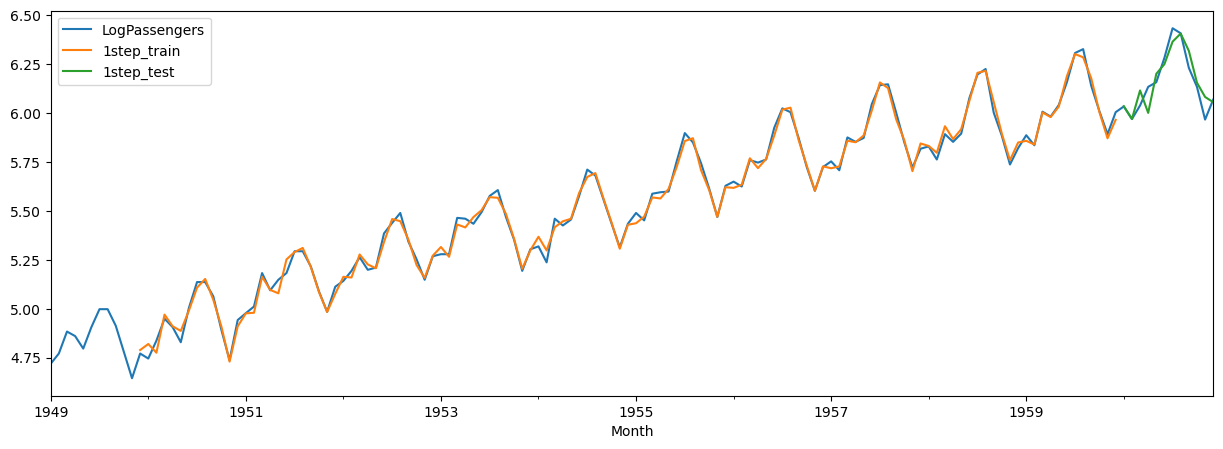

In [18]:
# plot 1-step forecast
df[['LogPassengers', '1step_train', '1step_test']].plot(figsize=(15, 5));

In [19]:
# multi-step forecast
multistep_predictions = []

# first test input
last_x = Xtest[0]

while len(multistep_predictions) < Ntest:
  p = model.predict(last_x.reshape(1, -1, 1))[0]
  
  # update the predictions list
  multistep_predictions.append(p)
  
  # make the new input
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

1/1 [==============================] - 0s 6ms/step


In [20]:
# save multi-step forecast to dataframe
df.loc[test_idx, 'multistep'] = last_train + np.cumsum(multistep_predictions)

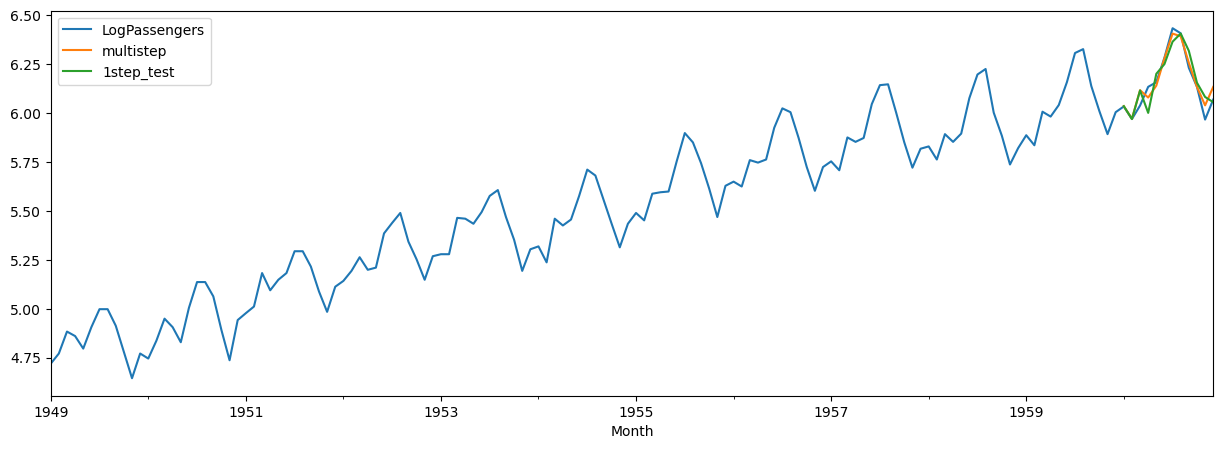

In [21]:

# plot 1-step and multi-step forecast
df[['LogPassengers', 'multistep', '1step_test']].plot(figsize=(15, 5));

In [22]:
# make multi-output supervised dataset
Tx = T
Ty = Ntest
X = []
Y = []
for t in range(len(series) - Tx - Ty + 1):
  x = series[t:t+Tx]
  X.append(x)
  y = series[t+Tx:t+Tx+Ty]
  Y.append(y)

X = np.array(X).reshape(-1, Tx, 1)
Y = np.array(Y).reshape(-1, Ty)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (122, 10, 1) Y.shape (122, 12)


In [23]:
Xtrain_m, Ytrain_m = X[:-1], Y[:-1]
Xtest_m, Ytest_m = X[-1:], Y[-1:]

In [24]:
# CNN
i = Input(shape=(Tx, 1))
x = Conv1D(16, 3, activation='relu')(i)
x = MaxPooling1D(2)(x)
x = Conv1D(32, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(Ty)(x)
model = Model(i, x)
model.compile(
  loss='mse',
  optimizer='adam',
)
r = model.fit(
  Xtrain_m,
  Ytrain_m,
  epochs=200,
  validation_data=(Xtest_m, Ytest_m)
)

Epoch 1/200
4/4 [==============================] - 0s 13ms/step - loss: 0.0119 - val_loss: 0.0111
Epoch 2/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0111 - val_loss: 0.0103
Epoch 3/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0107 - val_loss: 0.0098
Epoch 4/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0104 - val_loss: 0.0093
Epoch 5/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0102 - val_loss: 0.0088
Epoch 6/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0099 - val_loss: 0.0084
Epoch 7/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0097 - val_loss: 0.0081
Epoch 8/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0095 - val_loss: 0.0075
Epoch 9/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0092 - val_loss: 0.0070
Epoch 10/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0090 - val_loss: 0.0066
Epoch 11/200
4/4 [==========

4/4 [==============================] - 0s 3ms/step - loss: 0.0023 - val_loss: 0.0026
Epoch 85/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0023 - val_loss: 0.0026
Epoch 86/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0023 - val_loss: 0.0024
Epoch 87/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0022 - val_loss: 0.0025
Epoch 88/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0022 - val_loss: 0.0025
Epoch 89/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0022 - val_loss: 0.0026
Epoch 90/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0022 - val_loss: 0.0025
Epoch 91/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0021 - val_loss: 0.0026
Epoch 92/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0021 - val_loss: 0.0026
Epoch 93/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0021 - val_loss: 0.0026
Epoch 94/200
4/4 [===============

4/4 [==============================] - 0s 3ms/step - loss: 0.0015 - val_loss: 0.0032
Epoch 168/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0014 - val_loss: 0.0034
Epoch 169/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0014 - val_loss: 0.0035
Epoch 170/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0014 - val_loss: 0.0033
Epoch 171/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0014 - val_loss: 0.0034
Epoch 172/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0014 - val_loss: 0.0036
Epoch 173/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0014 - val_loss: 0.0032
Epoch 174/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0014 - val_loss: 0.0032
Epoch 175/200
4/4 [==============================] - 0s 3ms/step - loss: 0.0014 - val_loss: 0.0035
Epoch 176/200
4/4 [==============================] - 0s 6ms/step - loss: 0.0014 - val_loss: 0.0033
Epoch 177/200
4/4 [=====

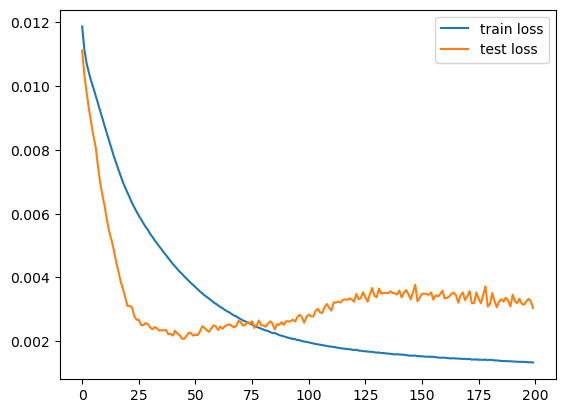

In [25]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

In [26]:
Ptrain = model.predict(Xtrain_m)
Ptest = model.predict(Xtest_m)


1/1 [==============================] - 0s 6ms/step


In [27]:
Ptrain.shape, Ptest.shape

((121, 12), (1, 12))

In [28]:
Ptrain = Ptrain[:,0]
Ptest = Ptest[0]

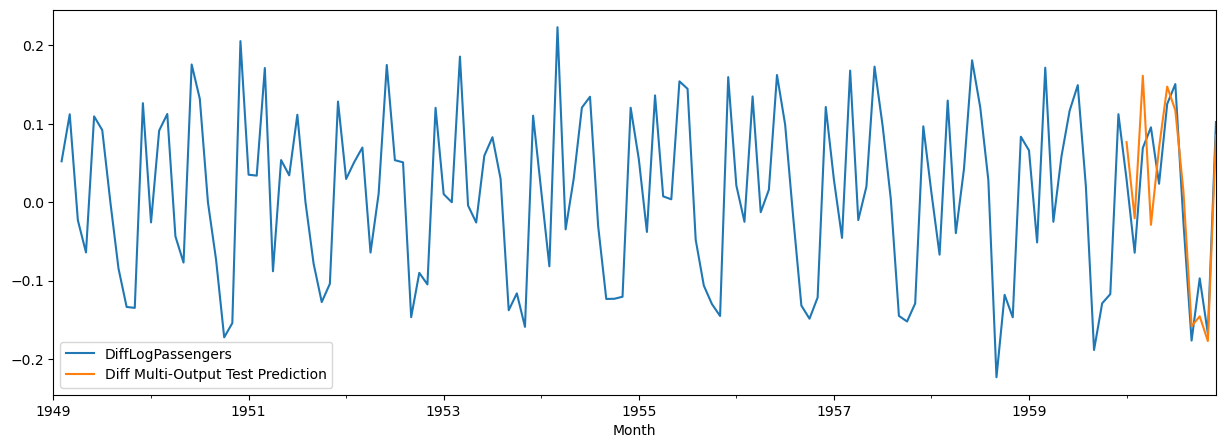

In [29]:
df.loc[test_idx, 'Diff Multi-Output Test Prediction'] = Ptest
cols = ['DiffLogPassengers', 'Diff Multi-Output Test Prediction']
df[cols].plot(figsize=(15, 5));

In [30]:
# save multi-output forecast to dataframe
df.loc[test_idx, 'multioutput'] = last_train + \
  np.cumsum(Ptest)

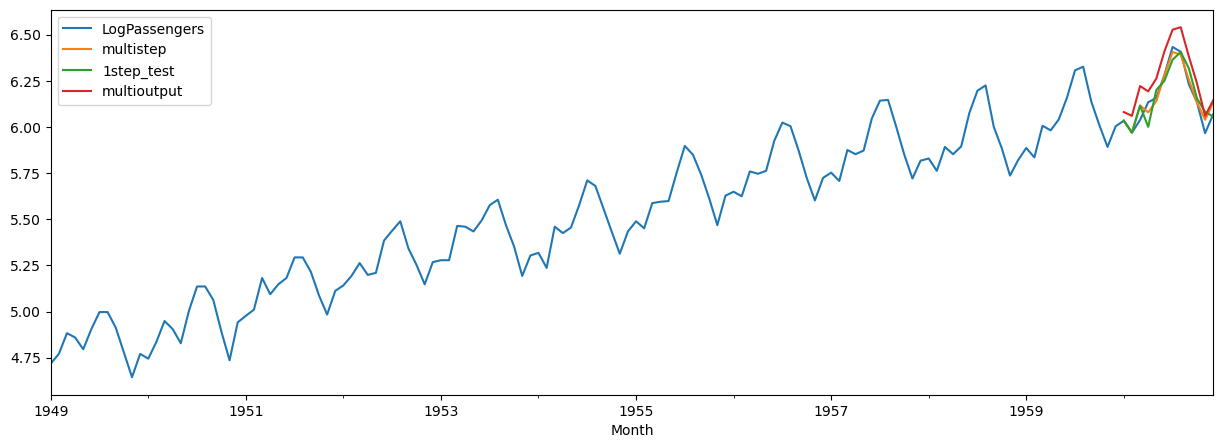

In [31]:
# plot all forecasts
cols = ['LogPassengers', 'multistep', '1step_test', 'multioutput']
df[cols].plot(figsize=(15, 5));

In [32]:
# MAPE
test_log_pass = df.iloc[-Ntest:]['LogPassengers']
mape1 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'multistep'])
print("multi-step MAPE:", mape1)
mape2 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'multioutput'])
print("multi-output MAPE:", mape2)

multi-step MAPE: 0.004937976104983981
multi-output MAPE: 0.017075355393539885


In [33]:
# Exercise:
# Do you think differencing is unnecessary? Try it!
# Do you think logging is unnecessary? Try it!
# Do you think including more past lags would be useful?
# Have you considered walk-forward validation to optimize hyperparameters?